# DolFin Transaction Classification
The purpose of this python notebook is to develop a NLP model that reads the transaction description and then classify the transaction into a category. The reasoning behind using BERT is because it is the current state of the art NLP model avalible and due to our lack of training data, transfer learning would be a practical solution.

# Libaries Requried
The following libaries are required for getting the model operational.

In [1]:
# Download and install the requied non-standard libaries required for the model
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install tokenization
!pip install transformers
!pip install tensorflow-hub


In [2]:
# Processing Utilities
import datetime
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import tokenization
from transformers import BertTokenizer

# Natural Language Processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, TFBertForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Deep learning
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import Model, layers

# Plotting utillities
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


# Data Labeling
The data is labeled into categories based on a keyword search. Using nested for loops, we itterate through each transaction description field and if a keyword matches then it will assign a class in the label feature.
The code can be modified into more classes or have more keywords added easily through ammeding the list, or including additional lists for new classes.

In [9]:
# Data location, batch and image size
dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/Projects/DolFin_Transaction_Classification/'
file_name = 'transaction_ut.csv'

# Load the dataset into a dataframe
df = pd.read_csv(dataset_dir + file_name)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Store the column names
labels = list(df.columns)

# Determine the shape of the data
num_samples = df.shape[0]
num_features = df.shape[1]

# Use keyword search to assign a class for each of the transactions
keyword_utiliity = ['energy', 'water', 'telecommunications', 'electricity']
keyword_income = ['payroll', 'wage', 'wages']
keyword_misc = ['atm', 'tran', 'transaction', 'fee']
keyword_loans = ['morggage', 'loan']


labels  = ['utility', 'income','misc','loans']

keyword_list = [keyword_utiliity, keyword_income, keyword_misc, keyword_loans]

# Apply our keyword search algorithm to the dataset, this can be improved.
for label, keyword in zip(labels, keyword_list):
    df['label'] = df.apply(lambda row: label if any(str(keyword).lower() in str(row['description']).lower() for keyword in keyword) else row['class'], axis=1)

# Create a label encoder for the classes and convert the text to integers
label = preprocessing.LabelEncoder()
y = label.fit_transform(df['label'])
y = to_categorical(y)



# Tokenization
Not all versions of BERT are compatable with TensorFlow, after trial and error it was found that some third party libaries with BERT are not supported by TensorFlow. The version of BERT that is compatable can be loaded from TensorHub, we then assign this model to the bert keras layer.
A specific tokenizer needs to be used with the BERT model, for the tokenizer we specify the vocab file and the word casing, then initalise the tokenizer.

In [10]:
# Download the bert model from TensorFlow Hub
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
# Create a keras layer with the model and set trainable to False
bert_layer = hub.KerasLayer(model_url, trainable=False)

# specify the vocab file for the bert model tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

# Specify for the tokenizer to change text to lower case
tokenizer_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

# Create a tokenizer instance
tokenizer = BertTokenizer(vocab_file, tokenizer_case)



# Preprocessing
The NLP model can not interperate plain text, it does however understand numbers which is done through tokenization. The function written below will convert a string of words into a list containing each individual word as an entry in the list, and then converted into a number representing each word. The list for each entry is then padded, where entris of zeros are added to ensure each list is the same length.

In [11]:

# Create a function that encodes the text as tokens for the BERT model
def bert_encode(texts, tokenizer, max_len=512):
    # Initialise the token, mask and segment lists
    all_tokens = []
    all_masks = []
    all_segments = []

    # Itterate through each of the transaction descriptions
    for text in texts:
        # Replace the entry with tokenized version of the entry
        text = tokenizer.tokenize(text)

        # Entries are trunkated to make room for two special tokens
        text = text[:max_len-2]
        # [CLS] is added to the start of the sequence and [SEP] to the end
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        # Pad the sequence, to ensure that all sequences are the same length
        pad_len = max_len-len(input_sequence)

        # BERT uses segment IDs to distinguish sentences, just set these to 0
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        # append the tokens, masks and segment IDs into the respective lists
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    # Return the output of the function
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Encode the training data using the preprocessing function above
max_len = 250
train_input = bert_encode(df['description'], tokenizer, max_len=max_len)
# Assign training labels
train_labels = y


labels = label.classes_
print(labels)



['bank-fee' 'cash-withdrawal' 'loans' 'payment' 'transfer']


In [12]:
# Build a function for generating the BERT classification model
def build_model(bert_layer, max_len=512):
    # The input layers correespond to inputs required by this version of BERT
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    # The pooled output is the BERT model layer which takes the three input layers
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    # The classifier output layer is used to extract the first token from the sequence
    # which is expected to be the [CLS] token added prior
    classifier_output = sequence_output[:, 0, :]

    # Create some dense layers for the classification portion of the model
    # Dropout layers are used to make the model more generalised.
    layer = tf.keras.layers.Dense(64, activation='relu')(classifier_output)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(32, activation='relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    output_layer = tf.keras.layers.Dense(5, activation='softmax')(layer)

    # Build the model based on the code we developed above and compile
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output_layer)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the model
    return model

# Create a model instance for our transaction classification
model = build_model(bert_layer, max_len=max_len)
# Display a summary of the model
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 250)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 250)]                0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  [(None, 768),                1094822   ['input_word_ids[0][0]',

# Training Model
Training the BERT model on the DolFin classification data is the same process as with standard TensorFlow classification models. I have included checkpointing and earlystopping into the callbacks to ensure that we have the best model and that it does not overfit the training data.

In [13]:
# Create our tensorboard callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
tensorflow_callbacks = [checkpoint, earlystopping]

# Specify the number of epoch, batch size and validation split
num_epochs = 10
batch_size = 32
val_split = 0.2

# Train the NLP model on the data and store its performance
history = model.fit(
    train_input, train_labels,
    validation_split=val_split,
    epochs=num_epochs,
    callbacks=tensorflow_callbacks,
    batch_size=batch_size,
    verbose=1
)

# Save a copy of the model
model.save_weights('BERT_model.h5')


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.5050
Epoch 1: val_accuracy improved from -inf to 0.97000, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 13s 402ms/step - loss: 1.2803 - accuracy: 0.5050 - val_loss: 0.8825 - val_accuracy: 0.9700
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.8450
Epoch 2: val_accuracy did not improve from 0.97000
13/13 [==============================] - 3s 223ms/step - loss: 0.7505 - accuracy: 0.8450 - val_loss: 0.4194 - val_accuracy: 0.9700
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.9350
Epoch 3: val_accuracy did not improve from 0.97000
13/13 [==============================] - 3s 224ms/step - loss: 0.3768 - accuracy: 0.9350 - val_loss: 0.1887 - val_accuracy: 0.9700
Epoch 3: early stopping


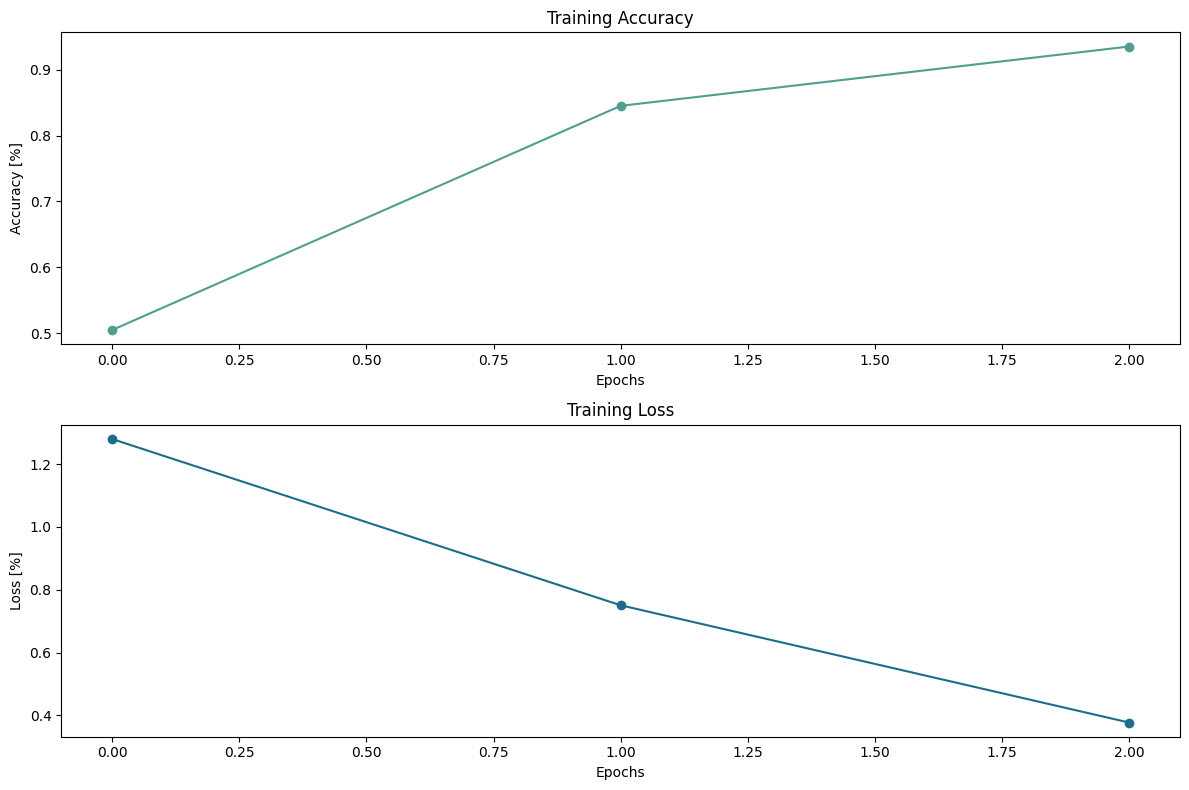

In [14]:
# Create a function to display the training accuracy and loss
def plt_accuracy_loss(history):
    # Plot the training history
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(len(accuracy))

    figure, ax = plt.subplots(2, 1, figsize=(12, 8))

    colors = sns.color_palette("crest", n_colors=2)

    ax[0].plot(epochs, accuracy, '-o', color=colors[0])
    ax[0].set_title('Training Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy [%]')

    ax[1].plot(epochs, loss, '-o', color=colors[1])
    ax[1].set_title('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss [%]')

    plt.tight_layout()
    plt.show()

plt_accuracy_loss(history)
